In [91]:
import numpy as np
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

In [92]:
timecalc = 9

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [93]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [94]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

In [95]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

In [96]:
# print all shapes
# print("nucleosomes[0].traj.shape", nucleosomes[0].traj.shape)
# print("nucleosomes[0].traj[0] : ", nucleosomes[0].traj[0])

# print all in and out times
# for n in nucleosomes:
#     print("nucleosome {} : in_time = {}, out_time = {}".format(n.p_ind, n.in_time, n.out_time))

In [97]:
# plot all trajectories with different colors for each nucleosome based on p_ind
# for n in nucleosomes:
#     color = np.random.rand(3,)
#     plt.scatter(n.traj[:, 1], n.traj[:, 2], color=color)

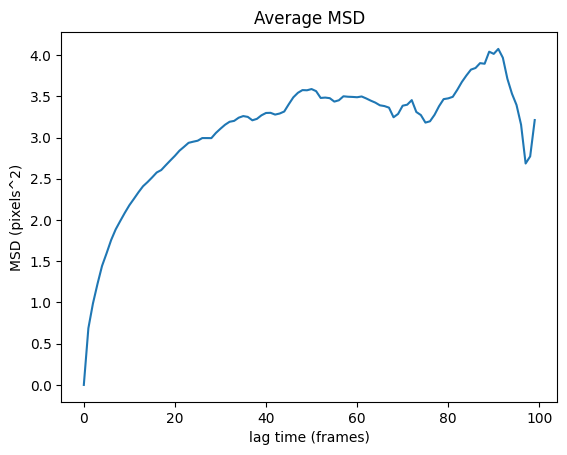

In [98]:
# calculate average MSD for each lag time 

num_frames = int(max(data[:, 1]))
if min(data[:, 1]) == 0:
    num_frames += 1

msd = np.zeros(num_frames)
msd_count = np.zeros(num_frames)

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        # print(n.traj[i,0])
        msd[i] += np.sum((n.traj[i:, 1:3] - n.traj[0:-i, 1:3])**2)
        msd_count[i] += n.traj.shape[0] - i

# average
msd[0] = 0
msd_count[0] = 1
msd = msd / msd_count
# print(msd)

# plot
plt.plot(msd)
plt.xlabel("lag time (frames)")
plt.ylabel("MSD (pixels^2)")
plt.title("Average MSD")
plt.show()

# save
np.savetxt("msd.txt", msd)


In [99]:
# calculate self part of van Hove function for each lag time
r_vals = np.arange(0, 10.01, 0.02)
# print(r_vals.shape)
van_hove = np.zeros((num_frames, r_vals.shape[0]-1))

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        dist = np.linalg.norm(n.traj[i:, 1:3] - n.traj[0:-i, 1:3], axis=1)
        hist, _ = np.histogram(dist, bins=r_vals)
        van_hove[i, :] += hist

# average
van_hove = van_hove / len(nucleosomes)

print(f"shape of van hove : {van_hove.shape}")

# save 
np.savetxt("van_hove.txt", van_hove)



shape of van hove : (100, 500)


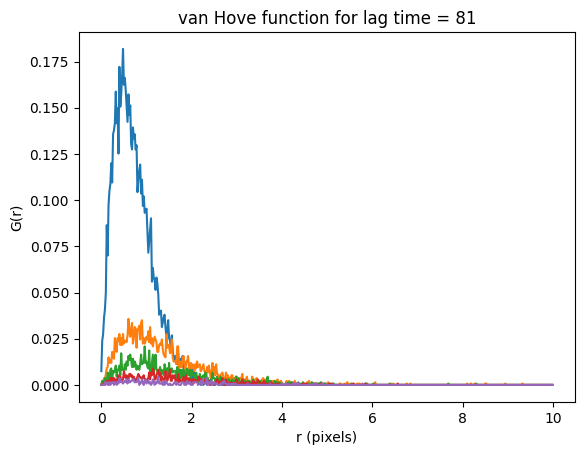

In [100]:
# plot van Hove function for lag time = i
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], van_hove[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"van Hove function for lag time = {i}")
    # plt.show()

Lucy-Richardson Iterative Algorithm

$\\$
$P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$, $\\ where \\$
$G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$

In [101]:
# get P_init as the guessed value of P(M, t)

P = np.zeros((num_frames, r_vals.shape[0]-1))
print(f"shape of P : {P.shape}")

# M_vals = np.linspace(0, max(msd), len(r_vals)-1)
M_vals = np.linspace(0, 25.0, len(r_vals)-1)
M_vals[0] = 1e-10
print(f"shape of M_vals : {M_vals.shape}")

shape of P : (100, 500)
shape of M_vals : (500,)


shape of G_pred : (100, 500)


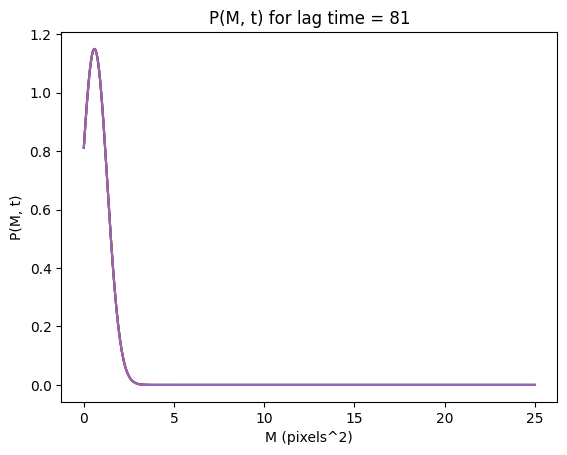

In [102]:
# initialize P
a1 = 1.15
a = 1.0
a0 = 0.59
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        P[i, j] = a1 * np.exp(-a * (M_vals[j] - a0)**2)
        # P[i, j] = a1 * np.exp(-a * (M_vals[j] - a0)**2)*i*(0.1)
P_old = P.copy()

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()

# integrate to get G_pred
G_pred = np.zeros((num_frames, r_vals.shape[0]-1))
print(f"shape of G_pred : {G_pred.shape}")

In [103]:
def integ1(G_pred, P, r_vals, M_vals):
    # try and integrate $G^k_s(r) = \int P^k(M)e^{\frac{-r^2}{M}}dM$
    # do this in a vectorized way using numpy

    # # integrate using trapezoidal rule over M
    # for i in range(G_pred.shape[0]):
    #     for j in range(G_pred.shape[1]):
    #         G_pred[i, j] = np.trapz(P[i, :] * np.exp(-r_vals[j] ** 2 / M_vals), M_vals)
    
    e_pow_r2_into_m = np.exp(np.outer(-r_vals[:-1]*r_vals[:-1], 1/M_vals))
    for i in range(G_pred.shape[0]):
        G_pred[i] = np.trapz(P[i, :] * e_pow_r2_into_m, M_vals)

    # normalize G_pred by dividing each element by sum of its row + 1
    G_pred = G_pred / (np.sum(G_pred, axis=1) + 1).reshape(-1, 1)
    # print(((np.sum(G_pred, axis=1) + 1).reshape(-1, 1)).shape)

    # shape
    # print(f"shape of G_pred : {G_pred.shape}")


def integ2(G_pred, P, r_vals, M_vals):
    # now update P using $P^{k+1}(M) = P^{k}(M) \int \frac{G_s(r)}{G^{k}_s(r)}e^{\frac{-r^2}{M}}dr$
    # do this in a vectorized way using numpy

    # update P
    # P_old = P.copy()
    # print(G_pred)
    for i in range(1, P.shape[0]):
        for j in range(P.shape[1]):
            P[i, j] = P[i, j] * np.trapz(
                van_hove[i, :] / G_pred[i, :]
                * np.exp(-r_vals[:-1] ** 2 / M_vals[j])
                * (2 * np.pi * r_vals[:-1]),
                r_vals[:-1],
            )

    # e_pow_r2_into_m = np.exp(np.outer(-r_vals[:-1]*r_vals[:-1], 1/M_vals))
    # arr = np.zeros((P.shape[0], P.shape[1]))
    # for i in range(1, P.shape[0]):
    #     arr[i] = np.trapz(van_hove[i, :] / G_pred[i, :] * e_pow_r2_into_m * (2 * np.pi * r_vals[:-1]), r_vals[:-1])
    #     # print((np.trapz(van_hove[i, :] / G_pred[i, :] * e_pow_r2_into_m * (2 * np.pi * r_vals[:-1]), r_vals[:-1])).shape)
    #     # P[i] = P[i] * np.trapz(van_hove[i, :] / G_pred[i, :] * e_pow_r2_into_m * (2 * np.pi * r_vals[:-1]), r_vals[:-1],)
    #     # P[i] = P[i] * np.trapz(van_hove[i, :] / G_pred[i, :] * np.exp(-r_vals[:-1] ** 2 / M_vals) * (2 * np.pi * r_vals[:-1]), r_vals[:-1],)
    # # print(arr.shape)
    # print(arr)
    # # append arr to file
    # with open("arr.txt", "a") as f:
    #     for item in arr:
    #         f.write("%s\n" % item)
    # P = P * arr

    # normalize P by dividing each element by sum of its row + 1
    P = P / (np.sum(P, axis=1) + 1).reshape(-1, 1)

    # shape
    # print(f"shape of P : {P.shape}")

In [104]:
# iterate until delta is small enough
delta = 10000
while delta > 1e-3:
    integ1(G_pred, P, r_vals, M_vals)
    integ2(G_pred, P, r_vals, M_vals)
    delta = np.sum((P - P_old)**2)
    print(f"delta : {delta}")
    P_old = P.copy()

delta : 2524.3379543762526
delta : 20.146972035923973
delta : 11.24897251554738
delta : 7.506065824312278
delta : 5.282043946834153
delta : 3.8511127721265854
delta : 2.931639745297611


KeyboardInterrupt: 

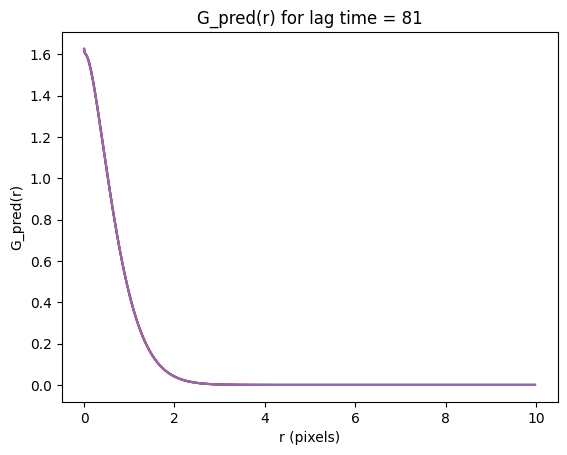

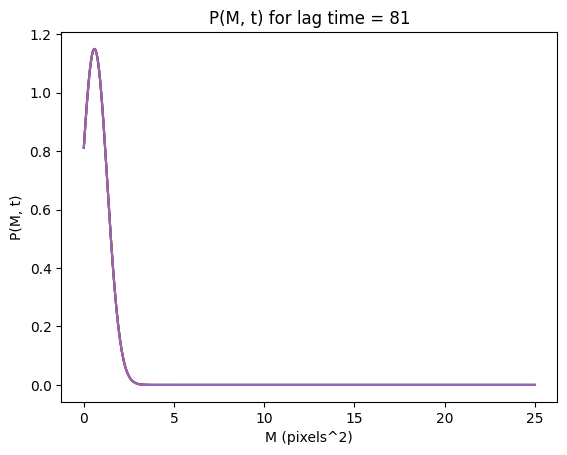

In [ ]:
# plot G_pred
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], G_pred[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G_pred(r)")
    plt.title(f"G_pred(r) for lag time = {i}")
    # plt.show()
plt.show()

# plot P
for i in range(1, num_frames, 20):
    plt.plot(M_vals, P[i, :])
    plt.xlabel("M (pixels^2)")
    plt.ylabel("P(M, t)")
    plt.title(f"P(M, t) for lag time = {i}")
    # plt.show()
plt.show()

# save P
np.savetxt("P.txt", P)
